<a href="https://colab.research.google.com/github/blackkker/mlc-ai/blob/main/mlc_exercises2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!python3 -m  pip install mlc-ai-nightly -f https://mlc.ai/wheels

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://mlc.ai/wheels


Import

In [ ]:
import IPython
import tvm
from tvm.ir.module import IRModule
from tvm.script import tir as T, relax as R
import numpy as np
from tvm import relax
# This is needed for deferring annotation parsing in TVMScript
from __future__ import annotations 

In [ ]:
def code2html(code):
    """Helper function to use pygments to turn the code string into highlighted html."""
    import pygments
    from pygments.lexers import Python3Lexer
    from pygments.formatters import HtmlFormatter
    formatter = HtmlFormatter()
    html = pygments.highlight(code, Python3Lexer(), formatter)
    return "<style>%s</style>%s\n" % (formatter.get_style_defs(".highlight"), html)

# 练习 1：广播加法
请编写一个 TensorIR 函数，将两个数组以广播的方式相加。

In [ ]:
# init data
a = np.arange(16).reshape(4, 4)
b = np.arange(4, 0, -1).reshape(4)

# numpy version
c_np = a + b
c_np

array([[ 4,  4,  4,  4],
       [ 8,  8,  8,  8],
       [12, 12, 12, 12],
       [16, 16, 16, 16]])

In [ ]:
@tvm.script.ir_module
class MyAdd:
  @T.prim_func
  def add(A:T.Buffer[(4,4),"int64"],
       B:T.Buffer[4,"int64"],
       C:T.Buffer[(4,4),"int64"]):
    T.func_attr({"global_symbol": "add", "tir.noalias": True})
    # TODO
    for i, j in T.grid(4, 4):
      with T.block("C"):
        vi = T.axis.spatial(4, i)
        vj = T.axis.spatial(4, j)
        C[vi, vj] = A[vi, vj] + B[vj]

rt_lib = tvm.build(MyAdd, target="llvm")
a_tvm = tvm.nd.array(a)
b_tvm = tvm.nd.array(b)
c_tvm = tvm.nd.array(np.empty((4, 4), dtype=np.int64))
rt_lib["add"](a_tvm, b_tvm, c_tvm)
np.testing.assert_allclose(c_tvm.numpy(), c_np, rtol=1e-5)
print("Pass!!!")

Pass!!!


# 练习 2：二维卷积
然后，让我们尝试做一些具有挑战性的事情：二维卷积。这是图像处理中的常见操作。

这是使用 NCHW 布局的卷积的数学定义：
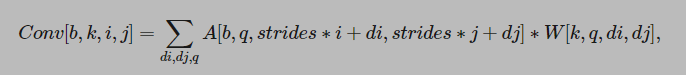

其中，A 是输入张量，W 是权重张量，b 是批次索引，k 是输出通道，i 和 j 是图像高度和宽度的索引，di 和 dj 是权重的索引，q 是输入通道，strides 是过滤器窗口的步幅。

在练习中，我们选择了一个小而简单的情况，即 stride=1, padding=0。

## Torch implement

In [ ]:
N, CI, H, W, CO, K = 1, 1, 8, 8, 2, 3
OUT_H, OUT_W = H - K + 1, W - K + 1
data = np.arange(N*CI*H*W).reshape(N, CI, H, W)
weight = np.arange(CO*CI*K*K).reshape(CO, CI, K, K)
print(data.shape)
print(weight.shape)

# torch version
import torch

data_torch = torch.Tensor(data)
weight_torch = torch.Tensor(weight)
conv_torch = torch.nn.functional.conv2d(data_torch, weight_torch)
conv_torch = conv_torch.numpy().astype(np.int64)
conv_torch

(1, 1, 8, 8)
(2, 1, 3, 3)


array([[[[ 474,  510,  546,  582,  618,  654],
         [ 762,  798,  834,  870,  906,  942],
         [1050, 1086, 1122, 1158, 1194, 1230],
         [1338, 1374, 1410, 1446, 1482, 1518],
         [1626, 1662, 1698, 1734, 1770, 1806],
         [1914, 1950, 1986, 2022, 2058, 2094]],

        [[1203, 1320, 1437, 1554, 1671, 1788],
         [2139, 2256, 2373, 2490, 2607, 2724],
         [3075, 3192, 3309, 3426, 3543, 3660],
         [4011, 4128, 4245, 4362, 4479, 4596],
         [4947, 5064, 5181, 5298, 5415, 5532],
         [5883, 6000, 6117, 6234, 6351, 6468]]]])

## IR_MODULE

In [ ]:
@tvm.script.ir_module
class MyConv:
  @T.prim_func
  def conv(A: T.Buffer[(N, CI, 8, 8), "int64"],
       B: T.Buffer[(CO, CI, K, K), "int64"], 
       C: T.Buffer[(N, CO, OUT_H, OUT_W), "int64"]):
    T.func_attr({"global_symbol": "conv", "tir.noalias": True})
    for b, k, i, j, q, di, dj in T.grid(N, CO, OUT_H, OUT_W, CI, K, K):
      with T.block("C"):
        vb, vk, vi, vj, vq, vdi, vdj = T.axis.remap("SSSSRRR", [b, k, i, j, q, di, dj])
        with T.init():
          C[vb, vk, vi, vj] = T.int64(0)
        C[vb, vk, vi, vj] = C[vb, vk, vi, vj] + A[vb, vq, vi + vdi, vj + vdj] * B[vk, vq, vdi, vdj]

## Compare

In [ ]:
rt_lib = tvm.build(MyConv, target="llvm")
data_tvm = tvm.nd.array(data)
weight_tvm = tvm.nd.array(weight)
conv_tvm = tvm.nd.array(np.empty((N, CO, OUT_H, OUT_W), dtype=np.int64))
rt_lib["conv"](data_tvm, weight_tvm, conv_tvm)
np.testing.assert_allclose(conv_tvm.numpy(), conv_torch, rtol=1e-5)
print("Pass!!!")

Pass!!!


# 练习 3：变换批量矩阵乘法程序

## numpy implement

In [ ]:
def lnumpy_mm_relu_v2(A: np.ndarray, B: np.ndarray, C: np.ndarray):
    Y = np.empty((16, 128, 128), dtype="float32")
    for n in range(16):
        for i in range(128):
            for j in range(128):
                for k in range(128):
                    if k == 0:
                        Y[n, i, j] = 0
                    Y[n, i, j] = Y[n, i, j] + A[n, i, k] * B[n, k, j]
    for n in range(16):
        for i in range(128):
            for j in range(128):
                C[n, i, j] = max(Y[n, i, j], 0)

## Tir implement

In [ ]:
@tvm.script.ir_module
class MyBmmRelu:
  @T.prim_func
  def bmm_relu(A: T.Buffer[(16, 128, 128),"float32"],
         B: T.Buffer[(16, 128, 128),"float32"],
         C: T.Buffer[(16, 128, 128),"float32"]):
    T.func_attr({"global_symbol": "bmm_relu", "tir.noalias": True})
    Y = T.alloc_buffer((16, 128, 128),"float32")
    for b, i, j, k in T.grid(16, 128, 128, 128):
      with T.block("Y"):
        vb, vi, vj, vk = T.axis.remap("SSSR", [b, i, j, k])
        with T.init():
          Y[vb, vi, vj] = T.float32(0)
        Y[vb ,vi, vj] = Y[vb,vi,vj] + A[vb, vi, vk] * B[vb, vk, vj]
    for b, i, j in T.grid(16, 128, 128):
      with T.block("C"):
        vb, vi, vj = T.axis.remap("SSS",[b, i, j])
        C[vb, vi, vj] = T.max(Y[vb ,vi, vj], T.float32(0))

# Also please validate your result

In [ ]:
sch = tvm.tir.Schedule(MyBmmRelu)
IPython.display.HTML(code2html(sch.mod.script()))

In [ ]:
dtype = "float32"
a_np = np.random.rand(16,128,128).astype(dtype)
b_np = np.random.rand(16,128,128).astype(dtype)
c_np = np.empty((16,128,128),dtype=dtype)
lnumpy_mm_relu_v2(a_np, b_np, c_np)

In [ ]:
a_nd = tvm.nd.array(a_np)
b_nd = tvm.nd.array(b_np)
c_nd = tvm.nd.empty((16,128,128), dtype="float32")
type(c_nd)

tvm.runtime.ndarray.NDArray

In [ ]:
rt_lib = tvm.build(MyBmmRelu, target="llvm")
bmmrelu = rt_lib["bmm_relu"]
bmmrelu(a_nd, b_nd, c_nd)
np.testing.assert_allclose(c_np, c_nd.numpy(), rtol=1e-5)
print("Pass!!!")

Pass!!!


## Transformation to target_mod

In [ ]:
sch = tvm.tir.Schedule(MyBmmRelu)
# TODO: transformations
# Hints: you can use
# `IPython.display.Code(sch.mod.script(), language="python")`
# or `print(sch.mod.script())`
# to show the current program at any time during the transformation.

# Step 1. Get blocks
Y = sch.get_block("Y", func_name="bmm_relu")

# Step 2. Get loops
b, i, j, k = sch.get_loops(Y)
sch.parallel(b)

# Step 3. Organize the loops
j0, j1 = sch.split(j, factors=[None, 8])  # 把128拆成16,8
sch.reorder(j0, k, j1)
block_C = sch.get_block("C", func_name="bmm_relu")
sch.reverse_compute_at(block_C, j0)

# Step 4. decompose reduction
Y_init = sch.decompose_reduction(Y, k)
_, _, _, j1_init = sch.get_loops(sch.get_block("Y_init", func_name="bmm_relu"))
k0, k1 = sch.split(k, factors=[None, 4])
_, _, _, ax0 = sch.get_loops(block_C)

# Step 5. vectorize / parallel / unroll
sch.vectorize(j1_init)
sch.vectorize(ax0)
sch.unroll(k1)
# print(sch.mod.script())

IPython.display.HTML(code2html(sch.mod.script()))

验证transform的mod是否与target mod等价

In [ ]:
@tvm.script.ir_module
class TargetModule:
    @T.prim_func
    def bmm_relu(A: T.Buffer[(16, 128, 128), "float32"], B: T.Buffer[(16, 128, 128), "float32"], C: T.Buffer[(16, 128, 128), "float32"]) -> None:
        T.func_attr({"global_symbol": "bmm_relu", "tir.noalias": True})
        Y = T.alloc_buffer([16, 128, 128], dtype="float32")
        for i0 in T.parallel(16):
            for i1, i2_0 in T.grid(128, 16):
                for ax0_init in T.vectorized(8):
                    with T.block("Y_init"):
                        n, i = T.axis.remap("SS", [i0, i1])
                        j = T.axis.spatial(128, i2_0 * 8 + ax0_init)
                        Y[n, i, j] = T.float32(0)
                for ax1_0 in T.serial(32):
                    for ax1_1 in T.unroll(4):
                        for ax0 in T.serial(8):
                            with T.block("Y_update"):
                                n, i = T.axis.remap("SS", [i0, i1])
                                j = T.axis.spatial(128, i2_0 * 8 + ax0)
                                k = T.axis.reduce(128, ax1_0 * 4 + ax1_1)
                                Y[n, i, j] = Y[n, i, j] + A[n, i, k] * B[n, k, j]
                for i2_1 in T.vectorized(8):
                    with T.block("C"):
                        n, i = T.axis.remap("SS", [i0, i1])
                        j = T.axis.spatial(128, i2_0 * 8 + i2_1)
                        C[n, i, j] = T.max(Y[n, i, j], T.float32(0))

In [ ]:
tvm.ir.assert_structural_equal(sch.mod, TargetModule)
print("Pass!!!")

Pass!!!


### Time evaluation

In [ ]:
before_rt_lib = tvm.build(MyBmmRelu, target="llvm")
after_rt_lib = tvm.build(sch.mod, target="llvm")
a_tvm = tvm.nd.array(np.random.rand(16, 128, 128).astype("float32"))
b_tvm = tvm.nd.array(np.random.rand(16, 128, 128).astype("float32"))
c_tvm = tvm.nd.array(np.random.rand(16, 128, 128).astype("float32"))
after_rt_lib["bmm_relu"](a_tvm, b_tvm, c_tvm)
before_timer = before_rt_lib.time_evaluator("bmm_relu", tvm.cpu())
print("Before transformation:")
print(before_timer(a_tvm, b_tvm, c_tvm))

f_timer = after_rt_lib.time_evaluator("bmm_relu", tvm.cpu())
print("After transformation:")
print(f_timer(a_tvm, b_tvm, c_tvm))

Before transformation:
Execution time summary:
 mean (ms)   median (ms)    max (ms)     min (ms)     std (ms)  
  54.1929      54.1929      54.1929      54.1929       0.0000   
               
After transformation:
Execution time summary:
 mean (ms)   median (ms)    max (ms)     min (ms)     std (ms)  
  16.3665      16.3665      16.3665      16.3665       0.0000   
               
